<a href="https://colab.research.google.com/github/alyson-mei/ml_stuff/blob/beta/language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poetry generation with NN

## Setup

In [1]:
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])

--2025-01-07 07:29:21--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.003s  

2025-01-07 07:29:22 (95.1 MB/s) - ‘onegin.txt’ saved [262521/262521]



## Char based approach

The most basic idea: predicting a token from a sequence of length N

### Tokenization and indexing

In [3]:
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

text_encoded = [token_to_idx[x] for x in text]

print(tokens)

['\n', ' ', '!', '(', ')', ',', '-', '.', '5', '7', '8', '9', ':', ';', '?', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '’', '…', '€', '<sos>']


In [4]:
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_batch():
    '''
    random start seq_length
    '''

    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))

    yield np.hstack((start_column, data))

N_TOKENS = num_tokens

In [5]:
batch = next(generate_batch())
batch

array([[83, 68, 50, ..., 51,  1, 60],
       [83, 50, 56, ...,  1, 47, 59],
       [83, 56, 58, ..., 50, 75, 70],
       ...,
       [83, 56, 73, ..., 59,  0, 58],
       [83, 45,  1, ..., 59, 47, 59],
       [83, 57,  1, ..., 59, 62, 63]])

### Train

In [6]:
def seqs_to_texts(sequences, idx_to_token):
    texts = []
    for seq in sequences:
        text = []
        for idx in seq:
            text.append(idx_to_token[int(idx)])
        texts.append(''.join(text))
    return texts

In [7]:
seqs_to_texts(batch[:5], idx_to_token)

['<sos>чела за данью полевой\nлетит из кельи восковой.\nдолины сохнут и пестреют;\nстада шумят, и соловей\nуж п',
 '<sos>ел в безмолвии ночей.\n\n\n\nii\n\nкак грустно мне твое явленье,\nвесна, весна! пора любви!\nкакое томное во',
 '<sos>лненье\nв моей душе, в моей крови!\nс каким тяжелым умиленьем\nя наслаждаюсь дуновеньем\nв лицо мне веющ',
 '<sos>ей весны\nна лоне сельской тишины!\nили мне чуждо наслажденье,\nи всё, что радует, живит,\nвсё, что лику',
 '<sos>ет и блестит,\nнаводит скуку и томленье\nна душу мертвую давно,\nи всё ей кажется темно?\n\n\n\niii\n\nили, н']

In [8]:
def outputs_top_k(outputs, idx_to_token, k = 5):
    top_k = []
    for output in outputs:
        top_tok = []
        top_ids = torch.argsort(output, descending = True)[:5]
        for idx in top_ids:
            top_tok.append(idx_to_token[int(idx)])
        top_k.append(top_tok)
    return top_k

In [9]:
test_output = F.softmax(torch.rand(4, N_TOKENS), dim = 1)
outputs_top_k(test_output, idx_to_token)

[['р', ')', '[', '€', 'й'],
 ['ы', 'c', 'ю', 'й', '5'],
 ['в', 'ж', '7', 'l', 'й'],
 ['<sos>', 'h', 'r', 'u', 'т']]

In [10]:
def train(model, optimizer, criterion, device = device, n_steps = 10000, eval_every = 100):
    loss_history = []
    running_loss = 0.0

    for step in tqdm(range(n_steps)):
        model.train()
        batch = torch.LongTensor(next(generate_batch())).to(device)
        input = batch[:, :-1]
        target = batch[:, -1]
        output, _ = model(input)
        output = output[:, -1, :]

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if step > 0 and step % eval_every == 0:
            model.eval()
            clear_output(wait = True)
            stt = seqs_to_texts(batch[:5], idx_to_token)
            otk = outputs_top_k(output[:5], idx_to_token)
            for i in range(5):
                print(f'{stt[i]} {otk[i]} \n')
            running_loss /= eval_every
            print(f'{eval_every} steps average loss {running_loss}')
            loss_history.append(running_loss)
            plt.plot(loss_history)
            plt.show()

### Eval

In [11]:
def generate_sample(char_rnn, seed_phrase = None, max_length = 200, temperature = 1.0, device = device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    model.eval()
    while len(x_sequence.squeeze()) < max_length:
        output, hidden = model(x_sequence[:, -100:])
        output = output.squeeze()[-1]
        output = F.softmax(output / temperature, dim = 0)
        idx = torch.multinomial(output, num_samples = 1)
        x_sequence = torch.cat([x_sequence, idx.reshape(1, 1)], dim = 1)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])

### Vanilla RNN

In [34]:
class RNN(nn.Module):

    def __init__(self, input_size = N_TOKENS, embedding_size = N_TOKENS, hidden_size = 256, num_layers = 1, dropout = 0.25):
        super().__init__()

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = 0.0 if num_layers == 1 else dropout
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers = num_layers, bidirectional = True, dropout = self.dropout, batch_first = True)
        self.decoder = nn.Linear(2 * hidden_size, input_size)

    def forward(self, X):
        X = self.embedding(X)
        X, hidden = self.rnn(X)
        X = self.decoder(X)
        return X, hidden

In [35]:
test_model = RNN().to(device)
batch = torch.LongTensor(next(generate_batch())).to(device)
input = batch[:, :-1]
target = batch[:, -1]
output, hidden = test_model(input)
print(output.shape, hidden.shape)

torch.Size([256, 100, 84]) torch.Size([2, 256, 256])


In [36]:
model = RNN(num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

<sos>одят,
мелькают профили голов
и дам и модных чудаков.



xxviii

вот наш герой подъехал к сеням;
швей ['р', 'т', 'л', 'з', 'д'] 

<sos>цара мимо он стрелой
взлетел по мраморным ступеням,
расправил волоса рукой,
вошел. полна народу зала ['о', 'е', 'м', 'и', 'т'] 

<sos>;
музыка уж греметь устала;
толпа мазуркой занята;
кругом и шум и теснота;
бренчат кавалергарда шпор ['р', 'й', 'в', 'ж', 'с'] 

<sos>ы;
летают ножки милых дам;
по их пленительным следам
летают пламенные взоры,
и ревом скрыпок заглуше ['и', 'н', 'а', 'е', 'к'] 

<sos>н
ревнивый шепот модных жен.



xxix

во дни веселий и желаний
я был от балов без ума:
верней нет ме ['е', 'о', 'и', 'ы', 'а'] 

100 steps average loss 1.5650253707293103


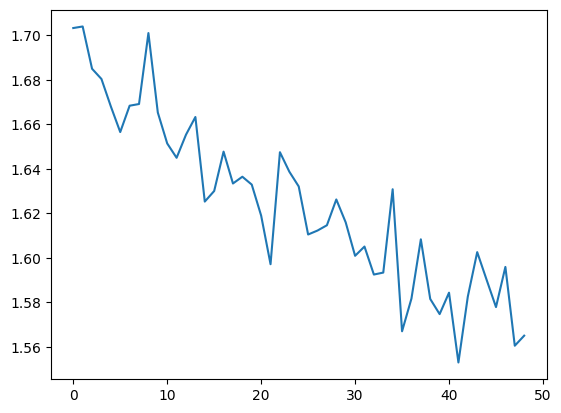

100%|██████████| 5000/5000 [04:08<00:00, 20.14it/s]


In [38]:
train(model, optimizer, criterion, n_steps = 5000)
optimizer.lr = 3e-4
train(model, optimizer, criterion, n_steps = 5000)

In [ ]:
#torch.save(model.state_dict(), 'basic_rnn')
#model.load_state_dict(torch.load('/content/basic_rnn', weights_only = True))

In [40]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length = 500, temperature = 0.6))

<sos> мой дядя самых честных правил:
со все всё теперь вновь на станом
и прочем ленского порой!
и ольге же отучно их.
так благословенные властво
и кричат может быть собая!
он сердце свои пущелая,
привычка светлою душою;
он совор и слушает своей.



xlii

старинчей моей домой взор
всё после по красною шель.
то всё которой возвратаясь вот
на вас оставленной ребене
пред своей надежду порог
вы сках, вдруг, бы не заменян,
в беспечно на шепчут и вздор;
все тайно светла таков бестра,
и всё берешь с вечер п


### GRU

In [41]:
class GRU(nn.Module):

    def __init__(self, input_size = N_TOKENS, embedding_size = N_TOKENS, hidden_size = 256, num_layers = 1, dropout = 0.25):
        super().__init__()

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = 0.0 if num_layers == 1 else dropout
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers = num_layers, bidirectional = True, dropout = self.dropout, batch_first = True)
        self.decoder = nn.Linear(2 * hidden_size, input_size)

    def forward(self, X):
        X = self.embedding(X)
        X, hidden = self.gru(X)
        X = self.decoder(X)
        return X, hidden

In [42]:
model = GRU(num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

<sos>дохи, скуку и обман
(и тем я начал мой роман);
но, прилетев в деревню дяди,
его нашел уж на столе,
к ['п', 'к', 'с', 'б', 'ч'] 

<sos>ак дань, готовую земле.



liii

нашел он полон двор услуги;
к покойнику со всех сторон
съезжались н ['в', 'с', 'т', 'н', 'р'] 

<sos>едруги и други,
охотники до похорон.
покойника похоронили.
попы и гости ели, пили
и после важно разо ['г', 'л', ' ', 'ъ', 'н'] 

<sos>шлись,
как будто делом занялись.
вот наш онегин – сельский житель,
заводов, вод, лесов, земель
хозяи ['т', 'р', 'и', 'н', 'м'] 

<sos>н полный, а досель
порядка враг и расточитель,
и очень рад, что прежний путь
переменил на что-нибудь ['ь', 'о', '\n', '.', 'с'] 

100 steps average loss 1.1064050694793819


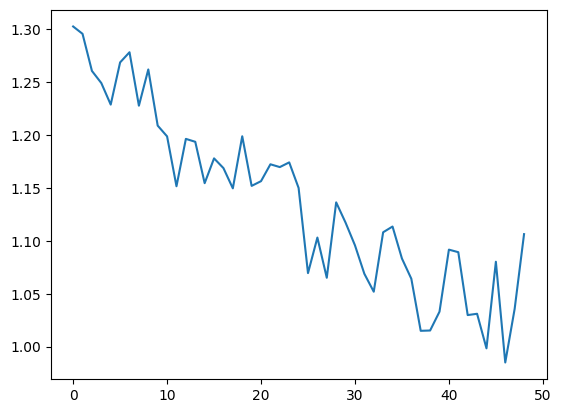

100%|██████████| 5000/5000 [09:24<00:00,  8.85it/s]


In [43]:
train(model, optimizer, criterion, n_steps = 5000)
optimizer.lr = 3e-4
train(model, optimizer, criterion, n_steps = 5000)

In [55]:
print(generate_sample(model, ' мой дядя самых честных правил,', max_length = 500, temperature = 0.8))

<sos> мой дядя самых честных правил,
гремят он уж тем русских стек
славно уж постепил сежных,
как сон мальчишки, внивых дев,
иль с который мечты первый,
ни судьбу, деревню не могу.
к тому ж не ты внуков на сона
к нему супруг мой полюбвиц
татьяну и собательной,
чтоб узнал: но чай не постов?



xxvii

земел в перед небрег и книго.
простите мужены (всем,
как лань, тот быль сначая в ленском.
вот сбежалась я в тобой?» – «как часто,
на свете требую утратой!
«не может быть, тот же нет —
не мужая будет быва


In [56]:
#torch.save(model.state_dict(), 'gru')
#model.load_state_dict(torch.load('/content/gru', weights_only = True))

### GRU + Attention

In [92]:
class Attention(nn.Module):

    def __init__(self, embedding_size = N_TOKENS, attention_size = N_TOKENS):
        super().__init__()

        self.W_Q = nn.Linear(embedding_size, attention_size)
        self.W_K = nn.Linear(embedding_size, attention_size)
        self.W_V = nn.Linear(embedding_size, attention_size)
        self.attention_size = attention_size

    def forward(self, X):
        Q = self.W_Q(X)
        K = self.W_K(X)
        V = self.W_V(X)
        Z = F.softmax(Q @ K.transpose(1, 2) / (self.attention_size ** 0.5), dim = 1) @ V
        return Z

class GRU_Attention(nn.Module):

    def __init__(self, input_size = N_TOKENS, embedding_size = N_TOKENS, attention_size = N_TOKENS, hidden_size = 256, num_layers = 1, dropout = 0.25):
        super().__init__()

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.attention = Attention(embedding_size, attention_size)
        self.dropout = 0.0 if num_layers == 1 else dropout
        self.gru = nn.GRU(embedding_size + attention_size, hidden_size, num_layers = num_layers, bidirectional = True, dropout = self.dropout, batch_first = True)
        self.decoder = nn.Linear(2 * hidden_size, input_size)

    def forward(self, X):
        X = self.embedding(X)
        Z = self.attention(X)
        X = torch.cat((Z, X), dim = 2)
        X, hidden = self.gru(X)
        X = self.decoder(X)
        return X, hidden

In [93]:
test_attention = Attention().to(device)
batch_attn = torch.rand(batch_size, 100, N_TOKENS).to(device)
Z = test_attention(batch_attn)
print(Z.shape)

test_model = GRU_Attention(num_layers = 2).to(device)
batch = torch.LongTensor(next(generate_batch())).to(device)
input = batch[:, :-1]
target = batch[:, -1]
output, hidden = test_model(input)
print(output.shape, hidden.shape)

torch.Size([256, 100, 84])
torch.Size([256, 100, 84]) torch.Size([4, 256, 256])


In [94]:
model = GRU_Attention(num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

<sos>зою взлелеян,
всегда таков: нахмуря бровь,
садился он за клавикорды
и брал на них одни аккорды,
то,  [' ', ',', '\n', 'к', '.'] 

<sos>к ольге взоры устремив,
шептал: не правда ль? я счастлив.
но поздно; время ехать. сжалось
в нем серд ['д', 'ж', 'е', 'к', 'о'] 

<sos>це, полное тоской;
прощаясь с девой молодой,
оно как будто разрывалось.
она глядит ему в лицо.
«что  [' ', ',', '?', '-', 'б'] 

<sos>с вами?» – «так». – и на крыльцо.



xx

домой приехав, пистолеты
он осмотрел, потом вложил
опять их [' ', 'л', 'х', 'н', 'с'] 

<sos> в ящик и, раздетый,
при свечке, шиллера открыл;
но мысль одна его объемлет;
в нем сердце грустное н ['н', 'е', 'в', 'м', 'у'] 

100 steps average loss 0.9898949453178147


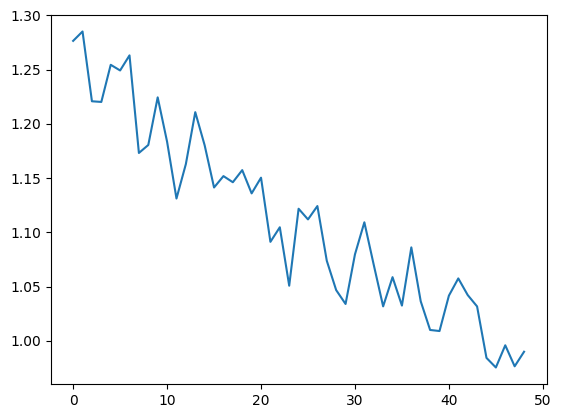

100%|██████████| 5000/5000 [10:37<00:00,  7.84it/s]


In [95]:
train(model, optimizer, criterion, n_steps = 5000)
optimizer.lr = 3e-4
train(model, optimizer, criterion, n_steps = 5000)

In [96]:
print(generate_sample(model, ' мой дядя самых честных правил,', max_length = 500, temperature = 0.8))

<sos> мой дядя самых честных правил,
и помелит… им обедам,
и он москва над ней одну;
но нейдесь оставил… сколько родне
стремлится просит пора;
господский жизни барышней
забыт и гордо стол окруженный
и блажен, красный мой обедом,
разливающий, при вкром,
и всё глуши младенческим обман
и завставах мне евгений,
и вприятный ждет: вот катилась
вы, как их затей отдаю.
теперь хвандик и слова:
сидит он оставил столина
с лирах шарю друго ль друзья?
где беготня отдвору,
про святым сердцем был когда,
без гордым


<sos> прощай, онегин, мне пора.
«я не держу тебя; но где ты
свои проводишь вечера?»
– у лариных. – «вот э ['н', 'о', 'с', 'б', 'е'] 

<sos>то чудно.
помилуй! и тебе не трудно
там каждый вечер убивать?»
– нимало. – «не могу понять.
отселе в ['т', 'п', 'в', 'г', 'д'] 

<sos>ижу, что такое:
во-первых (слушай, прав ли я?),
простая, русская семья,
к гостям усердие большое,
ва ['о', ' ', 'с', 'л', 'е'] 

<sos>ренье, вечный разговор
про дождь, про лён, про скотный двор…»



ii

– я тут еще беды не вижу.
«да с ['п', 'с', 'ч', 'к', 'в'] 

<sos>кука, вот беда, мой друг».
– я модный свет ваш ненавижу;
милее мне домашний круг,
где я могу… – «опя ['я', 'а', 'и', 'р', 'т'] 

100 steps average loss 0.9183779427370686


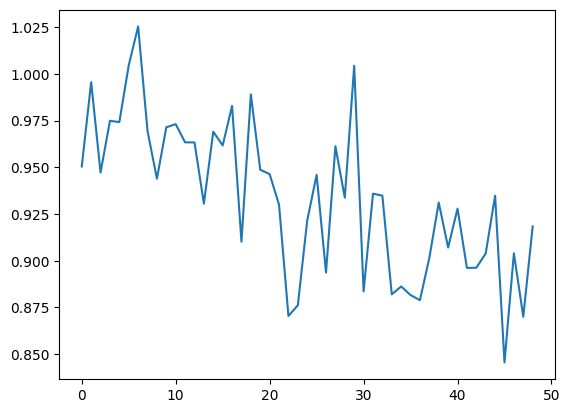

100%|██████████| 5000/5000 [10:38<00:00,  7.83it/s]


In [97]:
train(model, optimizer, criterion, n_steps = 5000)

In [105]:
print(generate_sample(model, ' мой дядя самых честных правил,', max_length = 500, temperature = 0.2))

<sos> мой дядя самых честных правил,
что подал бы изменилось!
как вечер. нет, никогда, нет безотрадной
картины слово кушал,
подобня предан во снегой
в то вдет в долго о том, о том,
какой судит со всех суждений,
и слов и мыслей модный взгляд,
перед хозяйки нам писать.



xxxi

как он, она подасти
сей флей подобен пустынный день,
о том не видя ничего —
вот от трепету голову;
да то, кто в скука сердцу грустно,
и записки надежды милой
увязнет наших судьбой,
москва мертвого под каблуком,
всё тот же скуку
